In [311]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as plt

In [312]:
class Queue:
    q = np.array([])
    
    def push(self, val):
        self.q = np.insert(self.q, len(self.q), val)
        
    def front(self):
        return self.q[0]
    
    def pop(self):
        val = self.q[0]
        self.q = np.delete(self.q, 0)
        return val
    
    def size(self):
        return self.q.size
    
    # vraca string, treba mi za print(class) poziv
    def __str__(self):
        return np.array2string(self.q, separator=', ')

In [313]:
def dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    q = Queue()
    trenutni_cvor = ciljni_cvor
    
    while trenutni_cvor != pocetni_cvor:
        q.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]
        
    q.push(trenutni_cvor)
            
    return q

In [314]:
# 1  procedure BFS(G, start_v) is
# 2      let Q be a queue
# 3      label start_v as discovered
# 4      Q.enqueue(start_v)
# 5      while Q is not empty do
# 6          v := Q.dequeue()
# 7          if v is the goal then
# 8              return v
# 9          for all edges from v to w in G.adjacentEdges(v) do
# 10             if w is not labeled as discovered then
# 11                 label w as discovered
# 12                 w.parent := v
# 13                 Q.enqueue(w)


def BFS(G, pocetni_cvor, ciljni_cvor):
    q = Queue()
    q.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(G), dtype=int)
    posjeceni_cvorovi[pocetni_cvor] = True
    
    roditelj_cvora = np.zeros(len(G), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;

    while q.size():
        trenutni_cvor = q.pop()
        print(trenutni_cvor, '\n')
        if trenutni_cvor == ciljni_cvor:
            return dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor)
        
        for susjedni_cvor in G[trenutni_cvor]:
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

0.0 

4.0 

3.0 

2.0 

6.0 

1.0 

5.0 

[5., 6., 3., 4., 0.]


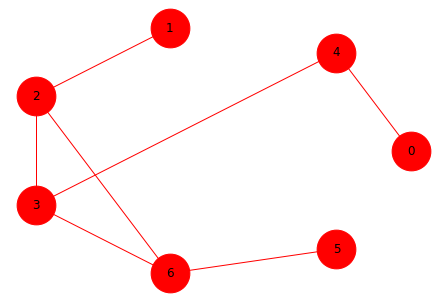

In [315]:

# s ovim generiram random povezan graf
#G = nx.generators.random_graphs.connected_watts_strogatz_graph(7, 3, 0.4, 100)
G = nx.Graph()
G.add_edges_from([(0, 4), (1, 2), (2, 3), (2, 6), (3, 6), (3, 4), (5, 6)], color='red')
A = nx.adjacency_matrix(G)

pocetni_cvor = 0
ciljni_cvor = 5

print(BFS(G, pocetni_cvor, ciljni_cvor))

boje = [G[u][v]['color'] for u,v in G.edges()]

pos = nx.circular_layout(G)
nx.draw(G, pos, node_size=1500, with_labels=True, edge_color=boje, node_color='red')
